<a href="https://colab.research.google.com/github/stefanziog/Quantized-Deep-Neural-Networks/blob/main/dynamic_range/cifar100_dynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import sys
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load train and test dataset
def load_dataset():
# load dataset
  data = keras.datasets.cifar100
  (train_images, train_labels), (test_images, test_labels) = data.load_data()
	
  return train_images, train_labels, test_images, test_labels

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
# load dataset
train_images, train_labels, test_images, test_labels = load_dataset()

# prepare pixel data
train_images, test_images = prep_pixels(train_images, test_images)

#load model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Διπλωματική Κώδικες τελικοί/saved_models/cifar100.h5')

169017344/169001437 [==============================] - 6s 0us/step


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5l0ba2o_/assets


In [ ]:
tflite_models_dir = pathlib.Path("/tmp/cifar100_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/"cifar100_model.tflite"
tflite_model_file.write_bytes(tflite_model)

2254156

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"cifar100_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpzoj8ix6r/assets


INFO:tensorflow:Assets written to: /tmp/tmpzoj8ix6r/assets


581152

In [ ]:
ls -lh {tflite_models_dir}

total 2.8M
-rw-r--r-- 1 root root 568K Sep 10 11:08 cifar100_model_quant.tflite
-rw-r--r-- 1 root root 2.2M Sep 10 11:08 cifar100_model.tflite


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

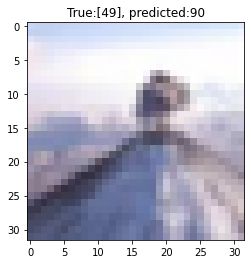

In [ ]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [ ]:
print(evaluate_model(interpreter))
print(evaluate_model(interpreter_quant))

0.4727
0.4724
